In [1]:
import pandas as pd
import numpy as np

# --- Carga de Datos (unir test4_complete y products_competition_clean) ---
# Intentamos cargar los archivos desde la carpeta actual (notebooks/) y, si no existen, desde ../data/
def read_first_existing(possible_paths):
    last_err = None
    for p in possible_paths:
        try:
            df = pd.read_csv(p)
            print(f"Cargado: {p}")
            return df, p
        except FileNotFoundError as e:
            last_err = e
            continue
    raise FileNotFoundError(f"No se encontró ninguno de los archivos: {possible_paths}")

# Posibles rutas para cada archivo
test4_paths = [
    'test4_complete.csv',            # notebooks/
    '../data/test4_complete.csv',    # data/
    'test_4complete.csv',            # variante nombre en notebooks/
    '../data/test_4complete.csv'     # variante nombre en data/
 ]
prod_comp_paths = [
    'products_competition_clean.csv',
    '../data/products_competition_clean.csv'
 ]

try:
    df_test4, used_path_test4 = read_first_existing(test4_paths)
    df_prod, used_path_prod = read_first_existing(prod_comp_paths)

    print("\n¡Archivos cargados exitosamente!")
    print(f"- test4: {used_path_test4} -> {df_test4.shape[0]} filas, {df_test4.shape[1]} columnas")
    print(f"- products_competition_clean: {used_path_prod} -> {df_prod.shape[0]} filas, {df_prod.shape[1]} columnas")

    # --- Unir ambos datasets ---
    competitor_data = pd.concat([df_test4, df_prod], ignore_index=True, sort=False)
    print(f"\nTotal combinado: {competitor_data.shape[0]} filas, {competitor_data.shape[1]} columnas")

    # --- Análisis Exploratorio ---
    print("\n--- Análisis de los Datos de la Competencia (Combinado) ---")
    print("\nPrimeras 5 filas del archivo combinado:")
    print(competitor_data.head())

    print("\nUnidades de medida únicas encontradas:")
    # Usamos .dropna() para ignorar nulos y .str.lower() para unificar 'ml' y 'ML', etc.
    unique_units = competitor_data['unit_of_measurement'].dropna().str.lower().unique()
    print(unique_units)

except FileNotFoundError as e:
    print(f"\nError: ¡No se pudo encontrar un archivo requerido! {e}")
    print("Por favor, verifica que los CSV existan en 'notebooks/' o en 'data/'.")
except Exception as e:
    print(f"\nOcurrió un error inesperado: {e}")

Cargado: test4_complete.csv
Cargado: products_competition_clean.csv

¡Archivos cargados exitosamente!
- test4: test4_complete.csv -> 1585 filas, 12 columnas
- products_competition_clean: products_competition_clean.csv -> 2104 filas, 8 columnas

Total combinado: 3689 filas, 16 columnas

--- Análisis de los Datos de la Competencia (Combinado) ---

Primeras 5 filas del archivo combinado:
        date industry subindustry         type_of_product  \
0  9/14/2025     Home        Home  H1-All purpose cleaner   
1  9/14/2025     Home        Home  H1-All purpose cleaner   
2  9/14/2025     Home        Home  H1-All purpose cleaner   
3  9/14/2025     Home        Home  H1-All purpose cleaner   
4  9/14/2025     Home        Home  H1-All purpose cleaner   

      generic_product_type                                            product  \
0  General purpose cleaner  Clorox Scentiva Spray, Multi-Surface Cleaner 5...   
1  General purpose cleaner  Clorox Multi-Purpose Cleaner Spray with Bleach...   
2 

In [2]:
# --- Separación de Datos ---
print("\n--- Separando los datos por tipo de medida ---")
volumetric_units = ['ml', 'l', 'fl oz', 'g']

print(f"Separando productos. Unidades consideradas como volumétricas: {volumetric_units}")

# Creamos una columna temporal en minúsculas para una comparación robusta
competitor_data['unit_of_measurement_lower'] = competitor_data['unit_of_measurement'].str.lower()

# Filtramos los DataFrames
volumetric_df = competitor_data[competitor_data['unit_of_measurement_lower'].isin(volumetric_units)].copy()
unit_df = competitor_data[~competitor_data['unit_of_measurement_lower'].isin(volumetric_units)].copy()

# Eliminamos la columna temporal que ya no necesitamos
volumetric_df.drop(columns=['unit_of_measurement_lower'], inplace=True)
unit_df.drop(columns=['unit_of_measurement_lower'], inplace=True)

print(f"\nResultado: Se encontraron {len(volumetric_df)} productos volumétricos y {len(unit_df)} productos por unidades.")

# --- Guardado de Archivos ---
volumetric_output_path = 'competitor_volumetric_products.csv'
unit_output_path = 'competitor_unit_products.csv'

volumetric_df.to_csv(volumetric_output_path, index=False)
unit_df.to_csv(unit_output_path, index=False)

print(f"\n¡Archivos generados exitosamente en tu carpeta!")
print(f"1. '{volumetric_output_path}'")
print(f"2. '{unit_output_path}'")


--- Separando los datos por tipo de medida ---
Separando productos. Unidades consideradas como volumétricas: ['ml', 'l', 'fl oz', 'g']

Resultado: Se encontraron 1442 productos volumétricos y 129 productos por unidades.

¡Archivos generados exitosamente en tu carpeta!
1. 'competitor_volumetric_products.csv'
2. 'competitor_unit_products.csv'


In [3]:
# --- Ingeniería de Características para Datos Volumétricos ---

# Cargar el conjunto de datos volumétricos que acabamos de crear
vol_file_path = 'competitor_volumetric_products.csv'

try:
    vol_df = pd.read_csv(vol_file_path)
    print(f"Archivo '{vol_file_path}' cargado. Contiene {len(vol_df)} filas.")

    # --- Normalización a Litros ---
    # Convertir 'total_quantity' a litros donde la unidad sea 'ml'
    # La lógica es: si la unidad es 'ml', divide la cantidad por 1000. Si es 'L', no hagas nada.
    vol_df['volume_liters'] = vol_df.apply(
        lambda row: row['total_quantity'] / 1000 if row['unit_of_measurement'].lower() == 'ml' else row['total_quantity'],
        axis=1
    )

    # --- Cálculo del Precio por Litro ---
    # Esta es nuestra variable objetivo (target) para el modelo
    # Nos aseguramos de manejar divisiones por cero o por volúmenes nulos.
    vol_df['price_per_liter'] = vol_df['price_sar'] / vol_df['volume_liters']
    vol_df.replace([np.inf, -np.inf], np.nan, inplace=True) # Reemplazar infinitos por NaN
    vol_df.dropna(subset=['price_per_liter'], inplace=True) # Eliminar filas donde el precio/L no se pudo calcular

    print("\nSe han añadido dos nuevas columnas: 'volume_liters' y 'price_per_liter'.")
    print("Ejemplo de los datos procesados:")
    print(vol_df[['product', 'price_sar', 'total_quantity', 'unit_of_measurement', 'volume_liters', 'price_per_liter']].head())

    # Guardamos el archivo procesado, listo para el entrenamiento
    vol_processed_path = 'competitor_volumetric_processed.csv'
    vol_df.to_csv(vol_processed_path, index=False)
    print(f"\nDatos volumétricos procesados y guardados en '{vol_processed_path}'. ¡Listos para entrenar el modelo!")


except FileNotFoundError:
    print(f"\nError: No se encontró el archivo '{vol_file_path}'.")
    print("Asegúrate de haber ejecutado el paso anterior correctamente.")
except Exception as e:
    print(f"Ocurrió un error: {e}")

Archivo 'competitor_volumetric_products.csv' cargado. Contiene 1442 filas.

Se han añadido dos nuevas columnas: 'volume_liters' y 'price_per_liter'.
Ejemplo de los datos procesados:
                                             product  price_sar  \
0  Clorox Scentiva Spray, Multi-Surface Cleaner 5...      18.45   
1  Clorox Multi-Purpose Cleaner Spray with Bleach...      20.95   
2  Dettol Lemon Healthy Home All Purpose Cleaner ...      18.99   
3  Mr. Muscle All Purpose Surface Cleaner Spray -...      15.95   
4        Clorox 409 All Purpose Cleaner Spray 750 ml      18.00   

   total_quantity unit_of_measurement  volume_liters  price_per_liter  
0           500.0                  ml           0.50        36.900000  
1           750.0                  ml           0.75        27.933333  
2           500.0                  ml           0.50        37.980000  
3           500.0                  ml           0.50        31.900000  
4           750.0                  ml           0.75   

Archivo 'competitor_volumetric_processed.csv' cargado para análisis.

--- Resumen Estadístico de 'price_per_liter' ---
count      1442.000000
mean        304.797755
std        5650.726645
min           0.017900
25%           6.187500
50%          15.000000
75%          67.046154
max      151360.000000
Name: price_per_liter, dtype: float64

--- Top 10 Productos con Mayor Precio por Litro ---
                                               product  price_sar  \
373  Nature’s Miracle Carpet Shampoo, Deep-Cleaning...     151.36   
818  Nature’s Miracle Carpet Shampoo, Deep-Cleaning...     151.36   
711                 Air Wick Vent Clip New Car, 2.5 Ml      29.95   
714  Air Wick Car Freshener, Mediterranean Sun Scen...      21.00   
504  Glade Touch & Fresh Aerosol Air Freshener for ...      83.56   
483  Tide To Go Compact and Portable Mess-Free Inst...      34.95   
720  Bliss Air Scents New Car Scented Deluxe Glass ...      15.95   
474                      Dr. Beckmann Stain Pen - 9 ml

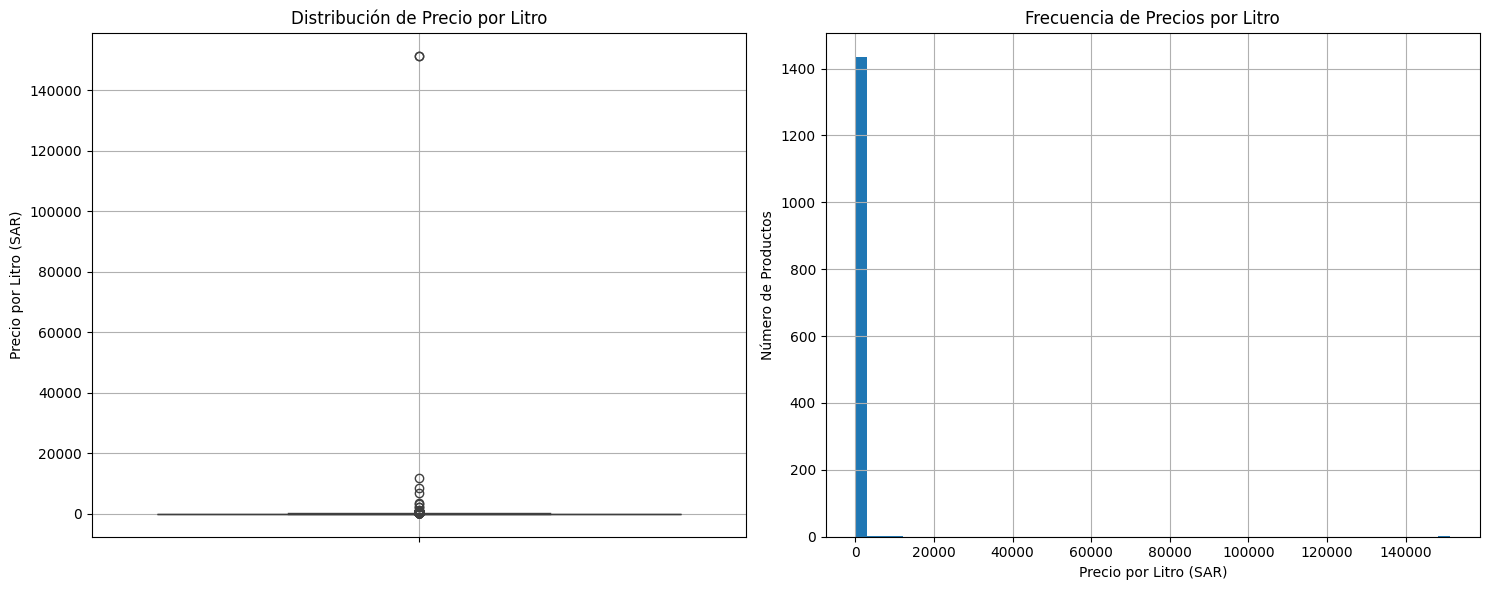

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Cargar los datos procesados que usamos para entrenar ---
processed_file_path = 'competitor_volumetric_processed.csv'

try:
    df_vol = pd.read_csv(processed_file_path)
    print(f"Archivo '{processed_file_path}' cargado para análisis.")

    # --- 1. Análisis Estadístico ---
    # .describe() nos dará un resumen rápido: media, desviación estándar, mínimo, máximo, etc.
    # Presta atención al valor 'max' y compáralo con el '75%' (tercer cuartil). Si la diferencia es enorme, hay outliers.
    print("\n--- Resumen Estadístico de 'price_per_liter' ---")
    print(df_vol['price_per_liter'].describe())

    # --- 2. Encontrar los Productos Más Caros por Litro ---
    # Ordenamos el DataFrame para ver cuáles son los productos que podrían estar causando problemas.
    print("\n--- Top 10 Productos con Mayor Precio por Litro ---")
    most_expensive = df_vol.sort_values(by='price_per_liter', ascending=False)
    print(most_expensive[['product', 'price_sar', 'volume_liters', 'price_per_liter']].head(10))

    # --- 3. Visualización de la Distribución ---
    print("\nGenerando gráficos para visualizar los datos...")
    
    plt.figure(figsize=(15, 6))

    # Gráfico de Caja (Boxplot) - La mejor herramienta para ver outliers
    plt.subplot(1, 2, 1)
    sns.boxplot(y=df_vol['price_per_liter'])
    plt.title('Distribución de Precio por Litro')
    plt.ylabel('Precio por Litro (SAR)')
    plt.grid(True)

    # Histograma para ver la frecuencia
    plt.subplot(1, 2, 2)
    df_vol['price_per_liter'].hist(bins=50)
    plt.title('Frecuencia de Precios por Litro')
    plt.xlabel('Precio por Litro (SAR)')
    plt.ylabel('Número de Productos')
    
    plt.tight_layout()
    plt.savefig('price_distribution_analysis.png')
    print("\nGráficos guardados como 'price_distribution_analysis.png' en tu carpeta.")
    
    print("\n--- Análisis Completo ---")
    print("Por favor, revisa las estadísticas y los gráficos generados.")
    print("Observa el valor 'max' en el resumen y los puntos individuales en el gráfico de caja (boxplot).")
    print("Estos son nuestros principales sospechosos (outliers).")


except FileNotFoundError:
    print(f"\nError: No se encontró el archivo '{processed_file_path}'.")
except Exception as e:
    print(f"Ocurrió un error inesperado: {e}")

In [6]:
import pandas as pd
import numpy as np

# --- Cargar los datos procesados (con outliers) ---
processed_file_path = 'competitor_volumetric_processed.csv'

try:
    df_vol = pd.read_csv(processed_file_path)
    print(f"Archivo '{processed_file_path}' cargado. Contiene {len(df_vol)} filas (antes de la limpieza).")

    # --- 1. Calcular el IQR para 'price_per_liter' ---
    Q1 = df_vol['price_per_liter'].quantile(0.25)
    Q3 = df_vol['price_per_liter'].quantile(0.75)
    IQR = Q3 - Q1

    # --- 2. Definir los límites para detectar outliers ---
    # La regla estándar es 1.5 veces el IQR por encima del tercer cuartil (Q3) o por debajo del primer cuartil (Q1)
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    print(f"\n--- Límites para la Detección de Outliers (Método IQR) ---")
    print(f"Primer Cuartil (Q1): {Q1:.2f}")
    print(f"Tercer Cuartil (Q3): {Q3:.2f}")
    print(f"Rango Intercuartílico (IQR): {IQR:.2f}")
    print(f"Límite superior permitido: {upper_bound:.2f} SAR/litro")
    print("Cualquier producto con un precio por litro por encima de este límite será eliminado.")

    # --- 3. Filtrar el DataFrame ---
    # Mantenemos solo las filas donde el 'price_per_liter' está dentro de los límites
    df_cleaned = df_vol[(df_vol['price_per_liter'] >= lower_bound) & (df_vol['price_per_liter'] <= upper_bound)]
    
    num_outliers_removed = len(df_vol) - len(df_cleaned)
    print(f"\nSe han eliminado {num_outliers_removed} outliers.")
    print(f"El conjunto de datos ahora tiene {len(df_cleaned)} filas.")

    # --- 4. Guardar el archivo final y limpio ---
    final_file_path = 'competitor_volumetric_final.csv'
    df_cleaned.to_csv(final_file_path, index=False)
    
    print(f"\n¡Limpieza completada! Los datos sin outliers se han guardado en:")
    print(f"'{final_file_path}'")
    
    # Verifiquemos el nuevo valor máximo para confirmar que la limpieza funcionó
    print("\n--- Nuevo Resumen Estadístico (Datos Limpios) ---")
    print(df_cleaned['price_per_liter'].describe())


except FileNotFoundError:
    print(f"\nError: No se encontró el archivo '{processed_file_path}'.")
except Exception as e:
    print(f"Ocurrió un error inesperado: {e}")

Archivo 'competitor_volumetric_processed.csv' cargado. Contiene 1442 filas (antes de la limpieza).

--- Límites para la Detección de Outliers (Método IQR) ---
Primer Cuartil (Q1): 6.19
Tercer Cuartil (Q3): 67.05
Rango Intercuartílico (IQR): 60.86
Límite superior permitido: 158.33 SAR/litro
Cualquier producto con un precio por litro por encima de este límite será eliminado.

Se han eliminado 177 outliers.
El conjunto de datos ahora tiene 1265 filas.

¡Limpieza completada! Los datos sin outliers se han guardado en:
'competitor_volumetric_final.csv'

--- Nuevo Resumen Estadístico (Datos Limpios) ---
count    1265.000000
mean       28.208351
std        36.617895
min         0.017900
25%         5.466667
50%        12.000000
75%        30.000000
max       157.605634
Name: price_per_liter, dtype: float64


In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# --- Cargar los datos procesados ---
processed_file_path = 'competitor_volumetric_final.csv'

try:
    df_vol = pd.read_csv(processed_file_path)
    print(f"Archivo '{processed_file_path}' cargado. Contiene {len(df_vol)} filas listas para el entrenamiento.")

    # --- 1. Definir Características (X) y Objetivo (y) ---
    # Seleccionamos las columnas que nos ayudarán a predecir.
    features = ['volume_liters', 'type_of_product']
    target = 'price_per_liter'

    X = df_vol[features]
    y = df_vol[target]

    # --- 2. One-Hot Encoding para la variable categórica ---
    # pd.get_dummies() convierte la columna 'type_of_product' en múltiples columnas (una por cada tipo de producto)
    # con valores de 1 o 0. Esto es crucial para que el modelo funcione.
    X_encoded = pd.get_dummies(X, columns=['type_of_product'], drop_first=True)
    
    print("\nLas características se han transformado a un formato numérico.")
    print("Ejemplo de las primeras filas de datos que verá el modelo (X_encoded):")
    print(X_encoded.head())

    # --- 3. Dividir los datos para Entrenamiento y Prueba ---
    # Dividimos los datos: 80% para entrenar y 20% para probar.
    # random_state=42 asegura que la división sea siempre la misma si ejecutamos el código de nuevo.
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
    print(f"\nDatos divididos: {len(X_train)} para entrenar, {len(X_test)} para probar.")

    # --- 4. Entrenar el Modelo de Random Forest ---
    print("\nEntrenando el modelo de Random Forest... Esto puede tardar unos segundos.")
    # n_estimators es el número de "árboles" en el bosque. Más árboles suelen dar mejores resultados, pero tarda más.
    # min_samples_leaf indica el número mínimo de muestras que debe tener una hoja final. Ayuda a prevenir el sobreajuste.
    model = RandomForestRegressor(n_estimators=100, random_state=42, min_samples_leaf=2, oob_score=True)
    model.fit(X_train, y_train)
    print("¡Modelo entrenado exitosamente!")

    # --- 5. Evaluar el Modelo ---
    # Hacemos predicciones sobre los datos de prueba (que el modelo nunca ha visto)
    predictions = model.predict(X_test)
    
    # Calculamos el Error Absoluto Medio (MAE)
    mae = mean_absolute_error(y_test, predictions)
    
    print("\n--- Evaluación del Modelo Volumétrico ---")
    print(f"Error Absoluto Medio (MAE): {mae:.2f} SAR por litro")
    print(f"Esto significa que, en promedio, las predicciones del modelo sobre el precio por litro se desvían en {mae:.2f} SAR del precio real.")
    print(f"Puntaje OOB (Out-of-Bag): {model.oob_score_:.4f}")
    print("El puntaje OOB es una medida de qué tan bien funciona el modelo, similar a la precisión. Un valor cercano a 1.0 es ideal.")


except FileNotFoundError:
    print(f"\nError: No se encontró el archivo '{processed_file_path}'.")
    print("Asegúrate de haber ejecutado el paso anterior (Paso 3) correctamente.")
except Exception as e:
    print(f"Ocurrió un error inesperado: {e}")

Archivo 'competitor_volumetric_final.csv' cargado. Contiene 1265 filas listas para el entrenamiento.

Las características se han transformado a un formato numérico.
Ejemplo de las primeras filas de datos que verá el modelo (X_encoded):
   volume_liters  type_of_product_A1-Leather conditioner  \
0           0.50                                   False   
1           0.75                                   False   
2           0.50                                   False   
3           0.50                                   False   
4           0.75                                   False   

   type_of_product_A2-Broad-spectrum disinfectant for surfaces  \
0                                              False             
1                                              False             
2                                              False             
3                                              False             
4                                              False             

   typ

In [8]:
import pandas as pd
import numpy as np

# --- Cargar los datos por unidades que separamos al inicio ---
unit_file_path = 'competitor_unit_products.csv'

try:
    unit_df = pd.read_csv(unit_file_path)
    print(f"Archivo '{unit_file_path}' cargado. Contiene {len(unit_df)} filas.")

    # --- 1. Limpieza de Cantidad ---
    # Nos aseguramos de que la columna 'total_quantity' sea numérica y manejamos posibles errores
    unit_df['total_quantity'] = pd.to_numeric(unit_df['total_quantity'], errors='coerce')
    # Eliminamos filas donde la cantidad no es válida (mayor que cero)
    unit_df.dropna(subset=['total_quantity'], inplace=True)
    unit_df = unit_df[unit_df['total_quantity'] > 0]

    # --- 2. Cálculo del Precio por Pieza/Unidad ---
    # Esta será nuestra variable objetivo para el segundo modelo.
    unit_df['price_per_item'] = unit_df['price_sar'] / unit_df['total_quantity']

    # Reemplazamos infinitos y eliminamos NaNs, igual que antes
    unit_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    unit_df.dropna(subset=['price_per_item'], inplace=True)

    print("\nSe ha añadido la columna 'price_per_item'.")
    print("Ejemplo de los datos ya procesados:")
    print(unit_df[['product', 'price_sar', 'total_quantity', 'unit_of_measurement', 'price_per_item']].head())

    # --- 3. Guardado del Archivo Procesado ---
    unit_processed_path = 'competitor_unit_processed.csv'
    unit_df.to_csv(unit_processed_path, index=False)

    print(f"\n¡Proceso completado! Los datos por unidades procesados se han guardado en:")
    print(f"'{unit_processed_path}'")

except FileNotFoundError:
    print(f"\nError: No se encontró el archivo '{unit_file_path}'.")
    print("Asegúrate de que el archivo 'competitor_unit_products.csv' (creado en el Paso 2) esté en tu carpeta.")
except Exception as e:
    print(f"Ocurrió un error inesperado: {e}")

Archivo 'competitor_unit_products.csv' cargado. Contiene 129 filas.

Se ha añadido la columna 'price_per_item'.
Ejemplo de los datos ya procesados:
                                             product  price_sar  \
0  Clorox Disinfecting Wipes, 35 Wet Wipes, Crisp...      21.45   
1  Clorox Disinfecting Wipes, 35 Wet Wipes, Fresh...      26.95   
2  Zoflora Midnight Blooms Biodegradable Surface ...      26.38   
3  Dettol Original Antibacterial Skin and Surface...      32.55   
4  HiPO Cleaner and Disinfectant Multipurpose Sur...      95.95   

   total_quantity unit_of_measurement  price_per_item  
0            35.0               units        0.612857  
1            35.0               units        0.770000  
2            96.0               units        0.274792  
3            40.0               units        0.813750  
4           300.0               units        0.319833  

¡Proceso completado! Los datos por unidades procesados se han guardado en:
'competitor_unit_processed.csv'


In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# --- Cargar los datos por unidades procesados ---
processed_unit_file = 'competitor_unit_processed.csv'

try:
    df_unit = pd.read_csv(processed_unit_file)
    print(f"Archivo '{processed_unit_file}' cargado. Contiene {len(df_unit)} filas.")
    print("\n--- Análisis Rápido de Outliers para 'price_per_item' ---")
    print(df_unit['price_per_item'].describe())
    
    # --- 1. Limpieza de Outliers (Método IQR) ---
    Q1 = df_unit['price_per_item'].quantile(0.25)
    Q3 = df_unit['price_per_item'].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR

    df_unit_cleaned = df_unit[df_unit['price_per_item'] <= upper_bound]
    
    outliers_removed = len(df_unit) - len(df_unit_cleaned)
    print(f"\nSe han eliminado {outliers_removed} outliers basados en el precio por item.")
    print(f"El conjunto de datos para entrenar ahora tiene {len(df_unit_cleaned)} filas.")

    # --- 2. Definir Características (X) y Objetivo (y) ---
    # Usamos 'total_quantity' (ej: número de esponjas en un paquete) y 'type_of_product'
    features = ['total_quantity', 'type_of_product']
    target = 'price_per_item'

    X = df_unit_cleaned[features]
    y = df_unit_cleaned[target]

    # --- 3. One-Hot Encoding y División de Datos ---
    X_encoded = pd.get_dummies(X, columns=['type_of_product'], drop_first=True)
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

    # --- 4. Entrenar el Segundo Modelo (Random Forest) ---
    print("\nEntrenando el modelo para productos por unidades...")
    model_unit = RandomForestRegressor(n_estimators=100, random_state=42, min_samples_leaf=2, oob_score=True)
    model_unit.fit(X_train, y_train)
    print("¡Modelo entrenado exitosamente!")

    # --- 5. Evaluar el Modelo ---
    predictions_unit = model_unit.predict(X_test)
    mae_unit = mean_absolute_error(y_test, predictions_unit)
    
    print("\n--- Evaluación del Modelo por Unidades ---")
    print(f"Error Absoluto Medio (MAE): {mae_unit:.2f} SAR por item")
    print(f"Esto significa que, en promedio, las predicciones del modelo sobre el precio por item se desvían en {mae_unit:.2f} SAR del precio real.")
    print(f"Puntaje OOB (Out-of-Bag): {model_unit.oob_score_:.4f}")

except FileNotFoundError:
    print(f"\nError: No se encontró el archivo '{processed_unit_file}'.")
    print("Asegúrate de haber ejecutado el Paso 7 correctamente.")
except Exception as e:
    print(f"Ocurrió un error inesperado: {e}")

Archivo 'competitor_unit_processed.csv' cargado. Contiene 129 filas.

--- Análisis Rápido de Outliers para 'price_per_item' ---
count    129.000000
mean       6.410038
std       15.414531
min        0.079500
25%        0.669750
50%        1.749583
75%        4.996667
max       88.310000
Name: price_per_item, dtype: float64

Se han eliminado 12 outliers basados en el precio por item.
El conjunto de datos para entrenar ahora tiene 117 filas.

Entrenando el modelo para productos por unidades...
¡Modelo entrenado exitosamente!

--- Evaluación del Modelo por Unidades ---
Error Absoluto Medio (MAE): 0.86 SAR por item
Esto significa que, en promedio, las predicciones del modelo sobre el precio por item se desvían en 0.86 SAR del precio real.
Puntaje OOB (Out-of-Bag): 0.6104


In [ ]:
import pandas as pd

try:
    # --- 1. Cargar los datos con los que se entrenaron los modelos ---
    df_vol_trained = pd.read_csv('competitor_volumetric_final.csv')
    df_unit_trained = pd.read_csv('competitor_unit_processed.csv') # Usamos este, ya que la limpieza de outliers se hizo en el script de entrenamiento

    # --- 2. Crear listas de los tipos de producto que cada modelo conoce ---
    trained_vol_types = set(df_vol_trained['type_of_product'].unique())
    trained_unit_types = set(df_unit_trained['type_of_product'].unique())
    
    # Combinamos ambas listas en un único conjunto para tener todos los tipos entrenables
    all_trained_types = trained_vol_types.union(trained_unit_types)
    
    print(f"Los modelos fueron entrenados en un total de {len(all_trained_types)} tipos de productos únicos.")

    # --- 3. Cargar tu archivo de productos Wayakit ---
    wayakit_products_file = 'body_wash_wayakit.csv'
    df_wayakit = pd.read_csv(wayakit_products_file)
    
    print(f"\nArchivo '{wayakit_products_file}' cargado. Contiene {len(df_wayakit)} productos en total.")

    # --- 4. Filtrar tu lista de productos ---
    # Mantenemos solo las filas donde el 'Type_of_product' existe en nuestra lista de tipos entrenados
    # Nota: El nombre de la columna en tu archivo es 'Type_of_product' (con mayúscula)
    df_wayakit_predictable = df_wayakit[df_wayakit['Type_of_product'].isin(all_trained_types)].copy()
    
    num_removed = len(df_wayakit) - len(df_wayakit_predictable)
    
    print(f"Se mantuvieron {len(df_wayakit_predictable)} productos para la predicción.")
    print(f"Se descartaron {num_removed} productos porque los modelos no fueron entrenados en esas categorías.")

    # --- 5. Guardar la lista filtrada, lista para la predicción final ---
    output_file = 'wayakit_products_to_predict.csv'
    df_wayakit_predictable.to_csv(output_file, index=False)
    
    print(f"\n¡Lista filtrada guardada! El archivo '{output_file}' está listo para el paso final.")


except FileNotFoundError as e:
    print(f"\nError: No se pudo encontrar un archivo necesario: {e.filename}")
    print("Asegúrate de que todos los archivos CSV generados en los pasos anteriores estén en la misma carpeta.")
except Exception as e:
    print(f"Ocurrió un error inesperado: {e}")

Los modelos fueron entrenados en un total de 173 tipos de productos únicos.

Archivo 'wayakit_products44.csv' cargado. Contiene 2176 productos en total.
Se mantuvieron 681 productos para la predicción.
Se descartaron 1495 productos porque los modelos no fueron entrenados en esas categorías.

¡Lista filtrada guardada! El archivo 'wayakit_products_to_predict.csv' está listo para el paso final.


In [ ]:
import pandas as pd
import joblib # Usaremos joblib para guardar y cargar nuestros modelos

# --- Guardar los modelos entrenados (Opcional pero muy recomendado) ---
# Esto crea archivos para que no tengas que volver a entrenar los modelos cada vez que abras el notebook.
# joblib.dump(model, 'volumetric_model.pkl')
# joblib.dump(model_unit, 'unit_model.pkl')
# print("Modelos guardados como 'volumetric_model.pkl' y 'unit_model.pkl'")


# --- Cargar el archivo de Wayakit filtrado, listo para la predicción ---
wayakit_predict_file = 'wayakit_products_to_predict.csv'

try:
    df_wayakit_predict = pd.read_csv(wayakit_predict_file)
    print(f"\nArchivo '{wayakit_predict_file}' cargado con {len(df_wayakit_predict)} productos listos para cotizar.")

    # --- Cargar las columnas de los datos de entrenamiento ---
    # Esto es VITAL para asegurar que los datos de predicción tengan la misma estructura que los datos de entrenamiento.
    # Obtenemos la lista de columnas después del One-Hot Encoding del set de entrenamiento volumétrico
    df_vol_trained = pd.read_csv('competitor_volumetric_final.csv')
    X_vol_template = pd.get_dummies(df_vol_trained[['volume_liters', 'type_of_product']], columns=['type_of_product'], drop_first=True)
    
    # Hacemos lo mismo para el set de entrenamiento por unidades
    df_unit_trained = pd.read_csv('competitor_unit_processed.csv')
    X_unit_template = pd.get_dummies(df_unit_trained[['total_quantity', 'type_of_product']], columns=['type_of_product'], drop_first=True)


    # --- Proceso de Predicción Iterativo ---
    predictions_list = []
    for index, row in df_wayakit_predict.iterrows():
        # Determinamos si el producto es volumétrico o por unidades basándonos en las columnas de cantidad
        is_volumetric = row['Volume_Liters'] > 0
        is_unit = row['Pack_quantity_Units'] > 0

        # Creamos un DataFrame temporal con la información del producto actual
        product_data_for_prediction = pd.DataFrame([row])

        if is_volumetric:
            # 1. Preparar datos para el modelo volumétrico
            product_data_for_prediction.rename(columns={'Type_of_product': 'type_of_product', 'Volume_Liters': 'volume_liters'}, inplace=True)
            X_pred = pd.get_dummies(product_data_for_prediction[['volume_liters', 'type_of_product']], columns=['type_of_product'])
            X_pred = X_pred.reindex(columns=X_vol_template.columns, fill_value=0) # Alineamos columnas con la plantilla
            
            # 2. Predecir el precio por litro y calcular el precio final
            predicted_price_per_liter = model.predict(X_pred)[0]
            final_suggested_price = predicted_price_per_liter * row['Volume_Liters']
            prediction_details = f"Predicción Volumétrica ({predicted_price_per_liter:.2f} SAR/L)"

        elif is_unit:
            # 1. Preparar datos para el modelo por unidades
            product_data_for_prediction.rename(columns={'Type_of_product': 'type_of_product', 'Pack_quantity_Units': 'total_quantity'}, inplace=True)
            X_pred = pd.get_dummies(product_data_for_prediction[['total_quantity', 'type_of_product']], columns=['type_of_product'])
            X_pred = X_pred.reindex(columns=X_unit_template.columns, fill_value=0) # Alineamos columnas con la plantilla

            # 2. Predecir el precio por item y calcular el precio final
            predicted_price_per_item = model_unit.predict(X_pred)[0]
            final_suggested_price = predicted_price_per_item * row['Pack_quantity_Units']
            prediction_details = f"Predicción por Unidades ({predicted_price_per_item:.2f} SAR/item)"
            
        else:
            final_suggested_price = 0
            prediction_details = 'Información de cantidad no encontrada'

        # Añadimos el resultado a nuestra lista de predicciones
        predictions_list.append({
            'Product_ID': row['Product_ID'],
            'Product_Name': row['Product_Name'], 
            'Type_of_product': row['Type_of_product'],
            'Suggested_Price_SAR': round(final_suggested_price, 2), 
            'Prediction_Details': prediction_details
        })

    # --- Mostrar y Guardar Resultados Finales ---
    results_df = pd.DataFrame(predictions_list)
    
    print("\n--- Precios Sugeridos para Productos Wayakit ---")
    print(results_df)

    results_df.to_csv('wayakit_suggested_prices.csv', index=False)
    print("\n¡PROYECTO COMPLETADO! 🚀")
    print("Los resultados finales han sido guardados en el archivo 'wayakit_suggested_prices.csv'")


except FileNotFoundError as e:
    print(f"\nError: No se pudo encontrar el archivo: {e.filename}")
except Exception as e:
    print(f"Ocurrió un error inesperado: {e}")

Modelos guardados como 'volumetric_model.pkl' y 'unit_model.pkl'

Archivo 'wayakit_products_to_predict.csv' cargado con 681 productos listos para cotizar.

--- Precios Sugeridos para Productos Wayakit ---
                                          Product_Name  \
0    WAYAKIT GreenTech Faith general purpose cleane...   
1    WAYAKIT GreenTech Faith general purpose cleane...   
2    WAYAKIT GreenTech Faith general purpose cleane...   
3    WAYAKIT GreenTech Faith general purpose cleane...   
4    WAYAKIT GreenTech Faith wood furniture cleaner...   
..                                                 ...   
676  WAYAKIT GreenTech Industrial Facilities Fabric...   
677      WAYAKIT GreenTech FM Leather cleaner [700 mL]   
678         WAYAKIT GreenTech FM Leather cleaner [4 L]   
679        WAYAKIT GreenTech FM Leather cleaner [20 L]   
680  WAYAKIT GreenTech FM Leather cleaner [Box of 1...   

                Type_of_product  Suggested_Price_SAR  \
0    I1-General purpose cleaner           